# Hurricane Clustering and ENSO/NAO Index

## Background

This project is based on the paper "Classifying North Atlantic tropical cyclone tracks by mass moments." Journal of Climate 22.20 (2009): [5481-5494](https://journals.ametsoc.org/configurable/content/journals$002fclim$002f22$002f20$002f2009jcli2828.1.xml?t:ac=journals%24002fclim%24002f22%24002f20%24002f2009jcli2828.1.xml) by Nakamura, Jennifer, et al.

In this paper, Nakamura et al. group North Atlantic hurricanes by geographic variables (the mean and variance of storm tracks) using K-means clustering. They find that using a vecor with five elements (longitudinal mean, latitudinal mean, longitudianl variance, latitudinal variance, and the covariance of latitude and longitude) provides good skill at grouping storms based on duration, location, and power dissipation index (PDI) which quantifies maximum wind speed and lifespan.

Our group wanted to extend this analysis by investigating the possible connections between large-scale, interannual climate processes and North Atlantic hurricane tracks. More specifically, we wondered if the clusters presented by Nakamura et al. (2009) would contain any information about ENSO, NAO, or AMM cycles.

Therefore, our goal in this notebook is to extend this analysis by testing the following hypothesis:

<p style="text-align: center;"><b>Including PDI in our hurricane clusters will improve their correlation with ENSO, NAO, and AMM indexes.</b></p>

Testing this hypothesis led us to a number of related inquiries, which are listed below and correspond to the headings of this notebook.

1) **What inputs should be given to the algorithm?** The paper only provides spatial information about a storm track based on its first two moments. We will test whether adding another metric to the clustering algorithm (PDI) will change the results.

2) **Which clustering algorithm should we use?** There are many different algorithms that cluster data. We will test three different methods (K-means, DBSCAN, and GMM) and compare the results.

3) **Which time span should we use for clustering?** The dataset of storms provided by NOAA has storms dating back to the mid 1800s. The reliability of this data increases with time, as the number of ground-based observations increases over time and the advent of satellite observations around 1980 provides more robust remote-sensing observations. So we must balance providing the algorithm with high-quality data vs a high volume of data.

After addressing each of these points, we will conclude the notebook with a section addressing our hypothesis directly by investigating the connections between hurricane cluster and ENSO, NAO or AMM index.

## Load packages, functions, and data

In [ ]:
#uncomment if necessary
#!pip install plotly

In [1]:
# import all necessary packages

import cartopy.crs as ccrs # used for map projection
import matplotlib.pyplot as plt # matplotlib
import cartopy.feature as cfeature # used for map projection
import xarray as xr # x-array
import numpy as np # numpy
import pandas as pd
import urllib.request # download request
import warnings # to suppress warnings
from numpy import linalg as LA # to plot the moments (by calculating the eigenvalues)
from sklearn.cluster import k_means # to perform k-means
from collections import Counter # set operations
warnings.filterwarnings('ignore')

In [2]:
# import functions our group has written

from func_tools import time_functions as tf      #making time selections in the data
from func_tools import helper_functions as hf    #clustering algorithms
from func_tools import plotting_functions as pf  #making plots

In [3]:
#check if a data directory exists
#if not, create a new directory

import os
cwd=os.getcwd()

cwd_data=cwd+'/data'

if not os.path.exists(cwd_data):
    os.mkdir(cwd_data)

Below is the hurricane track data we are using for this project, called [IBTrAcs](https://www.ncei.noaa.gov/products/international-best-track-archive). This cell will open the data specified in the URL and save it under the data folder created above.

In [4]:
# Download the needed track file

filedata = urllib.request.urlopen('https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc')

datatowrite = filedata.read()

with open('data/NA_data.nc', 'wb') as f:   
    f.write(datatowrite)

In [5]:
#load this file as an xarray dataset

tks = xr.open_dataset('data/NA_data.nc', engine="netcdf4", decode_times=False)
tks

<xarray.Dataset> Size: 618MB
Dimensions:           (storm: 2344, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) float64 7MB ...
    lat               (storm, date_time) float32 3MB ...
    lon               (storm, date_time) float32 3MB ...
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/147)
    numobs            (storm) float32 9kB ...
    sid               (storm) |S13 30kB ...
    season            (storm) float32 9kB ...
    number            (storm) int16 5kB ...
    basin             (storm, date_time) |S2 2MB ...
    subbasin          (storm, date_time) |S2 2MB ...
    ...                ...
    reunion_gust      (storm, date_time) float32 3MB ...
    reunion_gust_per  (storm, date_time) float32 3MB ...
    usa_seahgt        (storm, date_time) float32 3MB ...
    usa_searad        (storm, date_time, quadrant) float32 14MB ...
    storm_speed       (storm, date_time) float32 3MB ...
    storm_dir         (storm, date_time) float32 3MB ...
Attributes: (12/49)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    history:                    Tue May 28 04:28:18 2024: ncks --no_abc --cnk...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    NCO:                        netCDF Operators version 4.8.1 (Homepage = ht...

## Clustering inputs

In [ ]:
# calculate moments and store additional variables (It takes a moment to calculate the moments)
storms = hf.get_storms_with_moments(storms=tks)

### Pre-processing the data (normalization & using standard deviation)

The goal of this section is to highlight the importance of pre-processing the variables before using them as an input in the clustering algorithm. Part of this process entails using the standard deviation instead of the variance since the variance has a different scale than the latitude and longitude sample mean, whereas the standard deviation has the same scale. Normalizing the data helps mantain all the variables in a similar scale. For instance, the covariance has a different scale as well.

#### Variables before pre-processing

Note that the variables without scaling can have significantly different extreme values, such as the longitude variance (e.g. 2414) vs the longitude mean (which is at a scale of -70). We show the clusters (qualitatively) before any pre-processing to later compare the plots after we have included additional variables.

In [ ]:
# non-normalized variables histogram
variables = get_no_norm_var_values(storms=storms)
pf.plot_histogram(variables=variables.T, group_labels=var_labels, nbins=1000)

# calculate k-mean clustering with just the moments
storms_no_pre = hf.storms_kmeans(storms=storms, k_clusters=__CLUSTERS__, get_variables=get_no_norm_var_values)

# plot k-means centroids
pf.plot_centroids(storms=storms_no_pre, title_name=f'K-means clustering result, {__CLUSTERS__} clusters| Without pre-processing', cmap_name='Set1')

#### Variables after pre-processing

After pre-processing the data, we can see all the variables are within 0 and 1

In [ ]:
# normalized variables histogram
normalized_variables = hf.get_norm_std_values(storms=storms)
pf.plot_histogram(variables=normalized_variables.T, group_labels=std_labels, nbins=1000)

### Clustering with Power Dissipation Index (PDI) as an input

Additionally, the Power Dissipation Index (PDI) is added as part of the input variables.

The Power Dissipation Index is defined as:

$$
PDI = \int_1^n V^3 dt
$$

where n is the number of time steps with dt in seconds and V is the wind velocity in meters per second giving units of PDI in cubic meters per second squared.

In [ ]:
# normalized variables histogram including pdi
normalized_pdi_variables = hf.get_norm_pdi_values(storms=storms)
pf.plot_histogram(variables=normalized_pdi_variables.T, group_labels=pdi_labels, nbins=1000)

## Clustering algorithms

### K-Means

In [ ]:
K-means is a clustering algorithm that paritions a dataset into similar groups based on the distance from the cluster centroids. Formally, k-means tries to solve:

$$
\mathop{\arg \min}\limits_{\bf S} \sum_{i=1}^{k}\sum_{\textbf{x} \in S_i} \Vert \textbf{x} - \bf{\mu_i} \Vert ^2
$$

where $\mu$ is the centroid of the cluster $S_i$

In [ ]:
# calculate k-mean clustering with just the moments
storms_kmeans = hf.storms_kmeans(storms=storms, k_clusters=__CLUSTERS__, get_variables=get_norm_pdi_values)

# quantify results with davis bouldin score
mask = hf.not_nan_mask(storms=storms)
kmeans_labels = storms_kmeans.cluster.values[mask]
db_score_kmeans = davies_bouldin_score(normalized_pdi_variables, kmeans_labels)

# plot k-means centroids
pf.plot_centroids(storms=storms_kmeans, title_name=f'K-means clustering result, {__CLUSTERS__} clusters| With pre-processing and PDI', cmap_name='Set1')

### DBSCAN

DBSCAN is a density based clustering algorithm that groups together points that are closely nearby, and marks as outliers points that have no or few nearby points. Formally, DBSCAN tries to solve
$$
\mathop{\arg \min}\limits_{d(p,q)\leq \epsilon \forall p, q \in C_i \forall C_i \in C} |C|
$$
where $d(p,q)$ gives the smallest $\epsilon$ such that two points p and q are density-connected.

In [ ]:
# calculate dbscan clustering with moments and PDI
storms_dbscan = hf.storms_dbscan(storms=storms, eps=0.035, min_samples=30, get_variables=get_norm_pdi_values)
pf.plot_centroids(storms=storms_dbscan, title_name=f'DBSCAN clustering result| With pre-processing and PDI', cmap_name='Set1')

# quantify results with davis bouldin score
dbscan_labels = storms_dbscan.cluster.values[mask]
db_score_dbscan = davies_bouldin_score(normalized_pdi_variables, dbscan_labels)

### Gaussian Mixture Models

GMM Clustering is a probabilistic clustering algorithm that assumes that the data is generated from a mixture of several Gaussian distributions with unknown parameters. The algorithm tries to maximize the likelihood of the data given the model. Formally, GMM tries to solve the following:
$$
\mathop{\arg \max}\limits_{\theta} \sum_{i=1}^{n} \log \left( \sum_{j=1}^{k} \pi_j N(\textbf{x}_i | \mu_j, \Sigma_j) \right)
$$
where $\pi_j$ is the mixing coefficient, $\mu_j$ is the mean of the j-th Gaussian, and $\Sigma_j$ is the covariance matrix of the j-th Gaussian.

GMM differs from K-means in that it assumes that the data is generated from a mixture of several Gaussian distributions, whereas K-means assumes that the data is generated from a single Gaussian distribution. Another difference is that GMM provides a probability of a point belonging to a cluster, whereas K-means assigns a point to a single cluster. GMM clusters can be non-spherical, whereas K-means clusters are always spherical.

In [ ]:
# calculate gaussian mixture model clustering with moments and PDI
storms_gmm = hf.storms_gmm(storms=storms, n_clusters=__CLUSTERS__, get_variables=get_norm_pdi_values)
pf.plot_centroids(storms=storms_gmm, title_name=f'GMM clustering result| With pre-processing and PDI', cmap_name='Set1')

# quantify results with davis bouldin score
gmm_labels = storms_gmm.cluster.values[mask]
db_score_gmm = davies_bouldin_score(normalized_pdi_variables, gmm_labels)

### Comparing Clustering Methods

#### **Davies Bouldin Score Comparison**

The Davies Bouldin Index is a relative score, meaning that it can be used to compare different clustering methods on the same dataset. The lower the score, the better the clustering. The score is defined as:

$$
DBI = \frac{1}{n} \sum_{i=1}^{n} \max_{j \neq i} \left( \frac{\sigma_i + \sigma_j}{d(c_i, c_j)} \right)
$$

where $n$ is the number of clusters, $\sigma_i$ is the average distance between points in cluster $i$ and the centroid of cluster $i$, and $d(c_i, c_j)$ is the distance between the centroids of clusters $i$ and $j$. The DBI is a measure of the average similarity between each cluster and its most similar cluster.

As we can see from the above cell, K-means clustering has a lower DBI score than the Gaussian Mixture Model AND DBSCAN. This means that K-means clustering is a better fit for this dataset.

In [ ]:
dbs_scores = pd.DataFrame([["K-means", db_score_kmeans],
                           ["Gaussian Mixture Model", db_score_gmm],
                           ["DBSCAN", db_score_dbscan]], columns=["Clustering Method", "Davies Bouldin Score"])

fig = px.bar(dbs_scores, x="Clustering Method", y="Davies Bouldin Score", color="Clustering Method", title="Clustering Methods Comparison (Davies Bouldin Score)")
fig.show()

### Box Plot Comparison

We took k-means with PDI as an input and normalization, which yield the best results, and compared it to the original results.

#### After: K-Means clustering with PDI input and data normalization

In [ ]:
df_new = hf.get_storms_summary_data(storms=storms_kmeans)
df_original = hf.get_storms_summary_data(storms=storms_no_pre)

pf.plot_clusters_box_whiskers(variables=df_new, y_name="pdi")

In [ ]:
pf.plot_clusters_box_whiskers(variables=df_new, y_name="lifespan(days)")

In [ ]:
pf.plot_clusters_box_whiskers(variables=df_new, y_name="max_wind_speed")

#### Before: K-Means clustering without PDI and no data normalization

In [ ]:
pf.plot_clusters_box_whiskers(variables=df_original, y_name="pdi")

In [ ]:
pf.plot_clusters_box_whiskers(variables=df_original, y_name="lifespan(days)")

In [ ]:
pf.plot_clusters_box_whiskers(variables=df_original, y_name="max_wind_speed")

## Time selection

The storm track dataset has hurricane data going back a very long time, however earlier data is less reliable because of less sophisticated observational techniques. Data from planes began in the 1940s and data from satellites began in the 1970s, each increasing the accuracy of hurricane data.

In this section of the notebook, we investigate how picking data from different time intervals impacts the effectiveness of clustering. Based on the above sections, we've chosen K-means clustering using PDI and standard deviation instead of variance.

In [7]:
# converts the time coordinate to datetime64 format
tks = tf.to_datetime64(tks)

# adds a new coordinate origin_year which is an integer of the year the storm formed
tks = tf.add_origin_year(tks)

In [11]:
# select storms across time periods
tks_1850_2023 = tf.select_years(tks, 1850, 2023)
tks_1900_2023 = tf.select_years(tks, 1900, 2023)
tks_1950_2023 = tf.select_years(tks, 1950, 2023)
tks_1980_2023 = tf.select_years(tks, 1980, 2023)
tks_2000_2023 = tf.select_years(tks, 2000, 2023)

In [12]:
def get_values(storms) -> list:
    mask = hf.not_nan_mask(storms=storms)
    values =  np.array([storms.lon_mean.values[mask],
                        storms.lat_mean.values[mask],
                        storms.lon_std.values[mask],
                        storms.lat_std.values[mask],
                        storms.lon_lat_cov.values[mask],
                        storms.pdi.values[mask]]).T
    return hf.normalize(variables=values)

In [13]:
__CLUSTERS__ = 6
storms_1850_2023 = hf.get_storms_with_moments(storms=tks_1850_2023)
storms_1850_2023 = hf.storms_kmeans(storms=storms_1850_2023, k_clusters=__CLUSTERS__, get_variables=get_values)

storms_1900_2023 = hf.get_storms_with_moments(storms=tks_1900_2023)
storms_1900_2023 = hf.storms_kmeans(storms=storms_1900_2023, k_clusters=__CLUSTERS__, get_variables=get_values)

storms_1950_2023 = hf.get_storms_with_moments(storms=tks_1950_2023)
storms_1950_2023 = hf.storms_kmeans(storms=storms_1950_2023, k_clusters=__CLUSTERS__, get_variables=get_values)

storms_1980_2023 = hf.get_storms_with_moments(storms=tks_1980_2023)
storms_1980_2023 = hf.storms_kmeans(storms=storms_1980_2023, k_clusters=__CLUSTERS__, get_variables=get_values)

storms_2000_2023 = hf.get_storms_with_moments(storms=tks_2000_2023)
storms_2000_2023 = hf.storms_kmeans(storms=storms_2000_2023, k_clusters=__CLUSTERS__, get_variables=get_values)

In [14]:
from sklearn.metrics import davies_bouldin_score

mask_1850_2023 = hf.not_nan_mask(storms=storms_1850_2023)
moment_1850_2023 = get_values(storms_1850_2023)
labels_1850_2023 = storms_1850_2023.cluster.values[mask_1850_2023]
db_1850_2023 = davies_bouldin_score(moment_1850_2023, labels_1850_2023)

mask_1900_2023 = hf.not_nan_mask(storms=storms_1900_2023)
moment_1900_2023 = get_values(storms_1900_2023)
labels_1900_2023 = storms_1900_2023.cluster.values[mask_1900_2023]
db_1900_2023 = davies_bouldin_score(moment_1900_2023, labels_1900_2023)

mask_1950_2023 = hf.not_nan_mask(storms=storms_1950_2023)
moment_1950_2023 = get_values(storms_1950_2023)
labels_1950_2023 = storms_1950_2023.cluster.values[mask_1950_2023]
db_1950_2023 = davies_bouldin_score(moment_1950_2023, labels_1950_2023)

mask_1980_2023 = hf.not_nan_mask(storms=storms_1980_2023)
moment_1980_2023 = get_values(storms_1980_2023)
labels_1980_2023 = storms_1980_2023.cluster.values[mask_1980_2023]
db_1980_2023 = davies_bouldin_score(moment_1980_2023, labels_1980_2023)

mask_2000_2023 = hf.not_nan_mask(storms=storms_2000_2023)
moment_2000_2023 = get_values(storms_2000_2023)
labels_2000_2023 = storms_2000_2023.cluster.values[mask_2000_2023]
db_2000_2023 = davies_bouldin_score(moment_2000_2023, labels_2000_2023)

Text(0.5, 1.0, '')

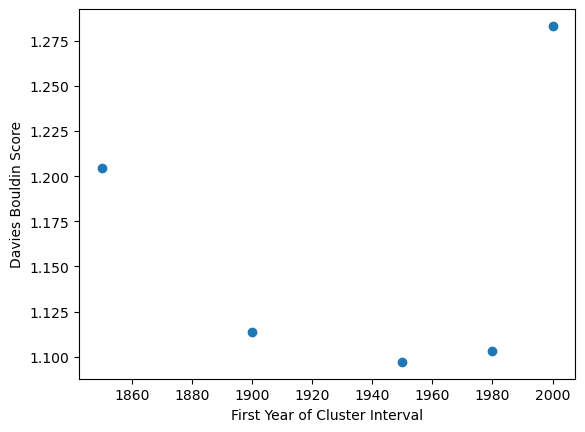

In [16]:
plt.scatter([1850, 1900, 1950, 1980, 2000], [db_1850_2023, db_1900_2023, db_1950_2023, db_1980_2023, db_2000_2023])
plt.xlabel('First Year of Cluster Interval')
plt.ylabel('Davies Bouldin Score')
plt.title('')

This plot shows the Davies Bouldin score for five time intervals:
- 1850-2023
- 1900-2023
- 1950-2023
- 1980-2023
- 2000-2023

where the year on the y-axis is the first year of the interval. This indicates that there is a trade-off between using high quality data and a high volume of data. Using all the available data is not the best because earlier years likely contain more mistakes, while only using recent data does not provide the algorithm with enough datapoints to make logical clusters.

Because of this test, we think the best interval is 1950-2023 because it provides the lowest Davies Bouldin scores, indicating this is the right balance between data quality and availability.

## ENSO/NAO Index

In [ ]:
obs = pd.read_csv('data/ObsSST_processed.csv')
amm = pd.read_csv('data/ObsAMM_processed.csv')
nao = pd.read_csv('data/ObsNAO_processed.csv')

In [ ]:
df_enso = df.merge(
    obs[["YR", "MON", "ANOM"]],              # take only needed columns
    left_on=["avg_year", "avg_month"],       # match columns on df
    right_on=["YR", "MON"],                  # match columns on obs
    how="left"                               # 'left' keeps all rows from df
)
df_enso = df_enso.rename(columns={"ANOM": "enso"})
df_enso = df_enso.drop(columns=["YR", "MON"])


df_amm = df.merge(
    amm[["YR", "MON", "AMM"]],
    left_on=["avg_year", "avg_month"],
    right_on=["YR", "MON"],
    how="left"
)
df_amm = df_amm.rename(columns={"AMM": "amm"})
df_amm = df_amm.drop(columns=["YR", "MON"])


df_nao = df.merge(
    nao[["Year", "MON", "NAO"]],
    left_on=["avg_year", "avg_month"],
    right_on=["Year", "MON"],
    how="left"
)
df_nao = df_nao.rename(columns={"NAO": "nao"})
df_nao = df_nao.drop(columns=["Year", "MON"])

In [ ]:
pf.plot_clusters_box_whiskers(variables=df_enso, y_name="enso")

In [ ]:
pf.plot_clusters_box_whiskers(variables=df_amm, y_name="amm")

In [ ]:
pf.plot_clusters_box_whiskers(variables=df_nao, y_name="nao")